<a href="https://colab.research.google.com/github/cha941006/ChaSeongMin/blob/master/2014122047_ChaSeongMin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project_Covid_19

학번 : 2014122047

성명 : 차성민

1. 문제의 정의
 - 현재 대한민국에서 코로나 19 사태가 장기화되고 있음에 따라 코로나 19 사태의 추이 분석을 통해 앞으로의 코로나 사태를 전망하고 이에 대비하는 것을 목표로 프로젝트를 진행한다. 기존의 시계열 분석방법인 ARIMA모형을 통한 분석과 또 다른 분석방법인 LSTM 방법을 통해 시계열 데이터를 예측하고자 한다.

2. Data 출처
- 코로나바이러스감염증-19 정식 홈페이지
   (http://ncov.mohw.go.kr/)
- Github - interglobe07/COVID-19-Korean-Data
   (https://github.com/interglobe07/COVID-19-Korean-Data)
- Github - ting2313/covid19_SouthKorea
   (https://github.com/ting2313/covid19_SouthKorea)

3. Data description

- daily : 일일 확진 환자 수 
- deacesd : 일일 사망자 수
- 20_confirmed : 20대 일일 확진 환자 수
- 60_confirmed : 60대 이상 일일 확진 환자 수
- 60_deceased : 60대 이상 일일 사망자 수



4. 코드 출처

- https://www.youtube.com/watch?v=h8v9--50mdU&t=948s

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")

# Import Data

In [0]:
df0 = pd.read_csv('daily.csv.csv')
df1 = pd.read_csv('deceased_Covid.csv')
df2 = pd.read_csv('20_confirmed.csv')
df3 = pd.read_csv('60_confirmed.csv')
df4 = pd.read_csv('60_deceased.csv')

In [0]:
df0.date = pd.to_datetime(df0.date)
df0 = df0.set_index('date')

df1.date = pd.to_datetime(df1.date)
df1 = df1.set_index('date')

df2.date = pd.to_datetime(df2.date)
df2 = df2.set_index('date')

df3.date = pd.to_datetime(df3.date)
df3 = df3.set_index('date')

df4.date = pd.to_datetime(df4.date)
df4 = df4.set_index('date')


In [0]:
split_date = pd.Timestamp('05-05-2020')


train0 = df0.loc[:split_date]
test0 = df0.loc[split_date:]

train1 = df1.loc[:split_date]
test1 = df1.loc[split_date:]

train2 = df2.loc[:split_date]
test2 = df2.loc[split_date:]

train3 = df3.loc[:split_date]
test3 = df3.loc[split_date:]

train4 = df4.loc[:split_date]
test4 = df4.loc[split_date:]


# confirmed culmulative 분석

In [0]:
scaler = MinMaxScaler()
scaler.fit(train0)
train0 = scaler.transform(train0)
test0 = scaler.transform(test0)

In [259]:
n_input = 30
n_features = 1

generator = TimeseriesGenerator(train0, train0, length = n_input, batch_size = 15)
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input,n_features)))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

model.fit_generator(generator, epochs=400)



Epoch 1/400
8/8 [==============================] - 1s 130ms/step - loss: 0.0290
Epoch 2/400
8/8 [==============================] - 1s 67ms/step - loss: 0.0238
Epoch 3/400
8/8 [==============================] - 1s 68ms/step - loss: 0.0191
Epoch 4/400
8/8 [==============================] - 1s 68ms/step - loss: 0.0173
Epoch 5/400
8/8 [==============================] - 1s 68ms/step - loss: 0.0156
Epoch 6/400
8/8 [==============================] - 1s 64ms/step - loss: 0.0156
Epoch 7/400
8/8 [==============================] - 1s 66ms/step - loss: 0.0140
Epoch 8/400
8/8 [==============================] - 1s 71ms/step - loss: 0.0126
Epoch 9/400
8/8 [==============================] - 1s 70ms/step - loss: 0.0120
Epoch 10/400
8/8 [==============================] - 1s 66ms/step - loss: 0.0124
Epoch 11/400
8/8 [==============================] - 1s 69ms/step - loss: 0.0124
Epoch 12/400
8/8 [==============================] - 1s 68ms/step - loss: 0.0108
Epoch 13/400
8/8 [==============================

In [0]:
pred_list0 = []

batch = train0[-n_input:].reshape((1,n_input,n_features))

for i in range(n_input):
  pred_list0.append(model.predict(batch)[0])
  batch = np.append(batch[:,1:,:],[[pred_list0[i]]],axis=1)


In [0]:
df0_predict =pd.DataFrame(scaler.inverse_transform(pred_list0),index=df0[-n_input:].index, columns=['Predictions'])


In [262]:
df_test0 = pd.concat([df0,df0_predict], axis =1)
df_test0

,daily,Predictions
date,,
2020-01-20,1,NaN
2020-01-21,0,NaN
2020-01-22,0,NaN
2020-01-23,0,NaN
2020-01-24,1,NaN
...,...,...
2020-06-12,56,0.139599
2020-06-13,48,0.149930
2020-06-14,34,0.161442


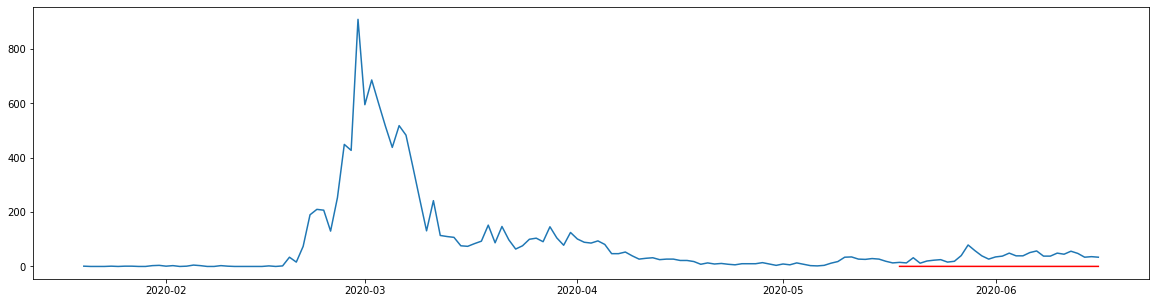

In [263]:
plt.figure(figsize=(20,5))
plt.plot(df_test0.index, df_test0['daily'])
plt.plot(df_test0.index, df_test0['Predictions'],color='r')
plt.show()

In [264]:
train0 = df0

scaler.fit(train0)
train0 = scaler.transform(train0)

n_input = 30
n_features = 1

generator = TimeseriesGenerator(train0, train0, length = n_input, batch_size = 15)


model.fit_generator(generator, epochs=100)

pred_list0 = []

batch = train0[-n_input:].reshape((1,n_input,n_features))

for i in range(n_input):
  pred_list0.append(model.predict(batch)[0])
  batch = np.append(batch[:,1:,:],[[pred_list0[i]]],axis=1)

from pandas.tseries.offsets import DateOffset

add_dates = [df0.index[-1]+ DateOffset( days= x) for x in range(0,31)]
future_dates = pd.DataFrame(index=add_dates[1:],columns= df0.columns)

df_predict0 = pd.DataFrame(scaler.inverse_transform(pred_list0),index = future_dates[-n_input:].index, columns=['Predictions'])
df_proj= pd.concat([df0,df_predict0], axis = 1)
  

Epoch 1/100
8/8 [==============================] - 1s 64ms/step - loss: 0.0015
Epoch 2/100
8/8 [==============================] - 1s 69ms/step - loss: 0.0013
Epoch 3/100
8/8 [==============================] - 1s 74ms/step - loss: 0.0014
Epoch 4/100
8/8 [==============================] - 1s 81ms/step - loss: 0.0015
Epoch 5/100
8/8 [==============================] - 1s 79ms/step - loss: 0.0014
Epoch 6/100
8/8 [==============================] - 1s 79ms/step - loss: 0.0012
Epoch 7/100
8/8 [==============================] - 1s 77ms/step - loss: 0.0015
Epoch 8/100
8/8 [==============================] - 1s 77ms/step - loss: 0.0014
Epoch 9/100
8/8 [==============================] - 1s 84ms/step - loss: 0.0020
Epoch 10/100
8/8 [==============================] - 1s 96ms/step - loss: 0.0013
Epoch 11/100
8/8 [==============================] - 1s 103ms/step - loss: 0.0018
Epoch 12/100
8/8 [==============================] - 1s 100ms/step - loss: 0.0014
Epoch 13/100
8/8 [=============================

In [265]:
df_proj.tail(60)

,daily,Predictions
2020-05-18,15.0,NaN
2020-05-19,13.0,NaN
2020-05-20,32.0,NaN
2020-05-21,12.0,NaN
2020-05-22,20.0,NaN
2020-05-23,23.0,NaN
2020-05-24,25.0,NaN
2020-05-25,16.0,NaN
2020-05-26,19.0,NaN
2020-05-27,40.0,NaN


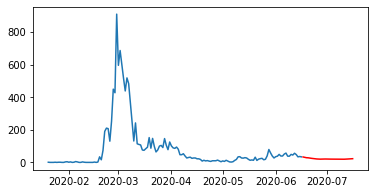

In [266]:
plt.figure(figsize=(6,3))
plt.plot(df_proj.index, df_proj['daily'])
plt.plot(df_proj.index, df_proj['Predictions'],color='red')
plt.show()

# deceased culmulative

In [247]:
scaler=MinMaxScaler()
scaler.fit(train1)
train1=scaler.transform(train1)
test1=scaler.transform(test1)

n_input=60
n_features=1

generator=TimeseriesGenerator(train1,train1,length=n_input,batch_size=15)
model=Sequential()
model.add(LSTM(200,activation='relu',input_shape=(n_input,n_features)))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

model.fit_generator(generator,epochs=100)

pred_list1=[]

batch=train1[-n_input:].reshape((1,n_input,n_features))

for i in range(n_input):
  pred_list1.append(model.predict(batch)[0])
  batch=np.append(batch[:,1:,:],[[pred_list1[i]]],axis=1)

df1_predict=pd.DataFrame(scaler.inverse_transform(pred_list1),index=df1[-n_input:].index,columns=['Predictions'])

df_test1=pd.concat([df1,df1_predict],axis=1)
df_test1

Epoch 1/100
4/4 [==============================] - 1s 215ms/step - loss: 0.1850
Epoch 2/100
4/4 [==============================] - 0s 107ms/step - loss: 0.1172
Epoch 3/100
4/4 [==============================] - 0s 116ms/step - loss: 0.0892
Epoch 4/100
4/4 [==============================] - 0s 110ms/step - loss: 0.0392
Epoch 5/100
4/4 [==============================] - 0s 111ms/step - loss: 0.0550
Epoch 6/100
4/4 [==============================] - 0s 112ms/step - loss: 0.0407
Epoch 7/100
4/4 [==============================] - 0s 112ms/step - loss: 0.0429
Epoch 8/100
4/4 [==============================] - 0s 110ms/step - loss: 0.0429
Epoch 9/100
4/4 [==============================] - 0s 111ms/step - loss: 0.0411
Epoch 10/100
4/4 [==============================] - 0s 106ms/step - loss: 0.0364
Epoch 11/100
4/4 [==============================] - 0s 113ms/step - loss: 0.0398
Epoch 12/100
4/4 [==============================] - 0s 114ms/step - loss: 0.0368
Epoch 13/100
4/4 [===================

,deceased,Predictions
date,,
2020-01-20,0,NaN
2020-01-21,0,NaN
2020-01-22,0,NaN
2020-01-23,0,NaN
2020-01-24,0,NaN
...,...,...
2020-05-27,0,0.320896
2020-05-28,0,0.321933
2020-05-29,0,0.350199


In [248]:
train1=df1

scaler.fit(train1)
train1=scaler.transform(train1)

n_input=60
n_features=1

generator=TimeseriesGenerator(train1,train1,length=n_input,batch_size=15)

model.fit_generator(generator,epochs=100)

pred_list1=[]

batch=train1[-n_input:].reshape((1,n_input,n_features))

for i in range(n_input):
  pred_list1.append(model.predict(batch)[0])
  batch=np.append(batch[:,1:,:],[[pred_list1[i]]],axis=1)


add_dates=[df1.index[-1]+DateOffset(days=x) for x in range(0,61)]
future_dates=pd.DataFrame(index=add_dates[1:],columns=df1.columns)

df_predict1=pd.DataFrame(scaler.inverse_transform(pred_list1),index=future_dates[-n_input:].index,columns=['Predictions'])
df_proj=pd.concat([df1,df_predict1],axis=1)
df_proj.tail(60)


Epoch 1/100
5/5 [==============================] - 1s 125ms/step - loss: 0.0345
Epoch 2/100
5/5 [==============================] - 1s 119ms/step - loss: 0.0268
Epoch 3/100
5/5 [==============================] - 1s 121ms/step - loss: 0.0275
Epoch 4/100
5/5 [==============================] - 1s 112ms/step - loss: 0.0255
Epoch 5/100
5/5 [==============================] - 1s 117ms/step - loss: 0.0258
Epoch 6/100
5/5 [==============================] - 1s 120ms/step - loss: 0.0241
Epoch 7/100
5/5 [==============================] - 1s 120ms/step - loss: 0.0228
Epoch 8/100
5/5 [==============================] - 1s 119ms/step - loss: 0.0224
Epoch 9/100
5/5 [==============================] - 1s 118ms/step - loss: 0.0220
Epoch 10/100
5/5 [==============================] - 1s 119ms/step - loss: 0.0215
Epoch 11/100
5/5 [==============================] - 1s 134ms/step - loss: 0.0212
Epoch 12/100
5/5 [==============================] - 1s 124ms/step - loss: 0.0249
Epoch 13/100
5/5 [===================

,deceased,Predictions
2020-06-01,NaN,0.638063
2020-06-02,NaN,0.626198
2020-06-03,NaN,0.614759
2020-06-04,NaN,0.604230
2020-06-05,NaN,0.594921
2020-06-06,NaN,0.586450
2020-06-07,NaN,0.579365
2020-06-08,NaN,0.573245
2020-06-09,NaN,0.567350
2020-06-10,NaN,0.562024


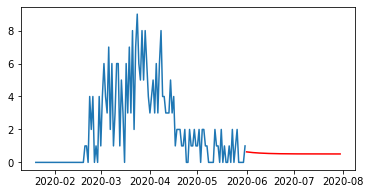

In [249]:
plt.figure(figsize=(6,3))
plt.plot(df_proj.index,df_proj['deceased'])
plt.plot(df_proj.index,df_proj['Predictions'],color='red')
plt.show()

# 20 culmulative

In [250]:
scaler=MinMaxScaler()
scaler.fit(train2)
train2=scaler.transform(train2)
test2=scaler.transform(test2)

n_input=60
n_features=1

generator=TimeseriesGenerator(train2,train2,length=n_input,batch_size=15)
model=Sequential()
model.add(LSTM(200,activation='relu',input_shape=(n_input,n_features)))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

model.fit_generator(generator,epochs=400)

pred_list2=[]

batch=train2[-n_input:].reshape((1,n_input,n_features))

for i in range(n_input):
  pred_list2.append(model.predict(batch)[0])
  batch=np.append(batch[:,1:,:],[[pred_list2[i]]],axis=1)

df2_predict=pd.DataFrame(scaler.inverse_transform(pred_list2),index=df2[-n_input:].index,columns=['Predictions'])

df_test2=pd.concat([df2,df2_predict],axis=1)
df_test2

Epoch 1/400
1/1 [==============================] - 1s 516ms/step - loss: 1.4182e-04
Epoch 2/400
1/1 [==============================] - 0s 86ms/step - loss: 5.2204e-05
Epoch 3/400
1/1 [==============================] - 0s 80ms/step - loss: 3.2667e-05
Epoch 4/400
1/1 [==============================] - 0s 80ms/step - loss: 4.8867e-05
Epoch 5/400
1/1 [==============================] - 0s 83ms/step - loss: 5.9456e-05
Epoch 6/400
1/1 [==============================] - 0s 77ms/step - loss: 4.7237e-05
Epoch 7/400
1/1 [==============================] - 0s 81ms/step - loss: 3.8337e-05
Epoch 8/400
1/1 [==============================] - 0s 80ms/step - loss: 3.0040e-05
Epoch 9/400
1/1 [==============================] - 0s 75ms/step - loss: 3.4238e-05
Epoch 10/400
1/1 [==============================] - 0s 79ms/step - loss: 3.7867e-05
Epoch 11/400
1/1 [==============================] - 0s 85ms/step - loss: 3.8348e-05
Epoch 12/400
1/1 [==============================] - 0s 82ms/step - loss: 3.8339e-05


,20_confirmed,Predictions
date,,
2020-03-03,182,NaN
2020-03-04,158,NaN
2020-03-05,152,NaN
2020-03-06,150,NaN
2020-03-07,161,NaN
...,...,...
2020-05-27,8,-0.19139
2020-05-28,15,-0.19139
2020-05-29,12,-0.19139


In [251]:
train2=df2

scaler.fit(train2)
train2=scaler.transform(train2)

n_input=60
n_features=1

generator=TimeseriesGenerator(train2,train2,length=n_input,batch_size=15)

model.fit_generator(generator,epochs=100)

pred_list2=[]

batch=train2[-n_input:].reshape((1,n_input,n_features))

for i in range(n_input):
  pred_list2.append(model.predict(batch)[0])
  batch=np.append(batch[:,1:,:],[[pred_list2[i]]],axis=1)


add_dates=[df2.index[-1]+DateOffset(days=x) for x in range(0,61)]
future_dates=pd.DataFrame(index=add_dates[1:],columns=df2.columns)

df_predict2=pd.DataFrame(scaler.inverse_transform(pred_list2),index=future_dates[-n_input:].index,columns=['Predictions'])
df_proj=pd.concat([df2,df_predict2],axis=1)
df_proj.tail(60)

Epoch 1/100
2/2 [==============================] - 0s 114ms/step - loss: 0.0015
Epoch 2/100
2/2 [==============================] - 0s 119ms/step - loss: 9.5330e-04
Epoch 3/100
2/2 [==============================] - 0s 117ms/step - loss: 0.0011
Epoch 4/100
2/2 [==============================] - 0s 111ms/step - loss: 8.8534e-04
Epoch 5/100
2/2 [==============================] - 0s 118ms/step - loss: 8.9694e-04
Epoch 6/100
2/2 [==============================] - 0s 121ms/step - loss: 8.7772e-04
Epoch 7/100
2/2 [==============================] - 0s 120ms/step - loss: 8.1948e-04
Epoch 8/100
2/2 [==============================] - 0s 114ms/step - loss: 8.4610e-04
Epoch 9/100
2/2 [==============================] - 0s 111ms/step - loss: 8.1109e-04
Epoch 10/100
2/2 [==============================] - 0s 117ms/step - loss: 8.0470e-04
Epoch 11/100
2/2 [==============================] - 0s 116ms/step - loss: 7.7875e-04
Epoch 12/100
2/2 [==============================] - 0s 122ms/step - loss: 7.6883e-

,20_confirmed,Predictions
2020-06-01,NaN,9.029674
2020-06-02,NaN,8.468154
2020-06-03,NaN,7.982677
2020-06-04,NaN,7.619629
2020-06-05,NaN,7.401686
2020-06-06,NaN,7.329895
2020-06-07,NaN,7.379125
2020-06-08,NaN,7.517253
2020-06-09,NaN,7.705063
2020-06-10,NaN,7.904192


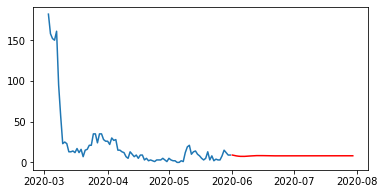

In [252]:
plt.figure(figsize=(6,3))
plt.plot(df_proj.index,df_proj['20_confirmed'])
plt.plot(df_proj.index,df_proj['Predictions'],color='red')
plt.show()

# Over 60 culmulative

In [253]:
scaler=MinMaxScaler()
scaler.fit(train3)
train3=scaler.transform(train3)
test3=scaler.transform(test3)

n_input=60
n_features=1

generator=TimeseriesGenerator(train3,train3,length=n_input,batch_size=15)
model=Sequential()
model.add(LSTM(200,activation='relu',input_shape=(n_input,n_features)))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

model.fit_generator(generator,epochs=100)

pred_list3=[]

batch=train3[-n_input:].reshape((1,n_input,n_features))

for i in range(n_input):
  pred_list3.append(model.predict(batch)[0])
  batch=np.append(batch[:,1:,:],[[pred_list3[i]]],axis=1)

df3_predict=pd.DataFrame(scaler.inverse_transform(pred_list3),index=df3[-n_input:].index,columns=['Predictions'])

df_test3=pd.concat([df3,df3_predict],axis=1)
df_test3

Epoch 1/100
1/1 [==============================] - 0s 464ms/step - loss: 2.9520e-04
Epoch 2/100
1/1 [==============================] - 0s 88ms/step - loss: 1.6428e-04
Epoch 3/100
1/1 [==============================] - 0s 80ms/step - loss: 1.5710e-04
Epoch 4/100
1/1 [==============================] - 0s 84ms/step - loss: 1.7052e-04
Epoch 5/100
1/1 [==============================] - 0s 83ms/step - loss: 1.7487e-04
Epoch 6/100
1/1 [==============================] - 0s 82ms/step - loss: 1.4733e-04
Epoch 7/100
1/1 [==============================] - 0s 100ms/step - loss: 1.2959e-04
Epoch 8/100
1/1 [==============================] - 0s 90ms/step - loss: 1.3096e-04
Epoch 9/100
1/1 [==============================] - 0s 85ms/step - loss: 1.3463e-04
Epoch 10/100
1/1 [==============================] - 0s 85ms/step - loss: 1.4789e-04
Epoch 11/100
1/1 [==============================] - 0s 86ms/step - loss: 1.3104e-04
Epoch 12/100
1/1 [==============================] - 0s 88ms/step - loss: 1.3377e-04

,60_confirmed,Predictions
date,,
2020-03-03,111,NaN
2020-03-04,100,NaN
2020-03-05,97,NaN
2020-03-06,160,NaN
2020-03-07,134,NaN
...,...,...
2020-05-27,12,2.001504
2020-05-28,6,2.001504
2020-05-29,11,2.001504


In [254]:
train3=df3

scaler.fit(train3)
train3=scaler.transform(train3)

n_input=60
n_features=1

generator=TimeseriesGenerator(train3,train3,length=n_input,batch_size=15)

model.fit_generator(generator,epochs=100)

pred_list3=[]

batch=train3[-n_input:].reshape((1,n_input,n_features))

for i in range(n_input):
  pred_list3.append(model.predict(batch)[0])
  batch=np.append(batch[:,1:,:],[[pred_list3[i]]],axis=1)


add_dates=[df3.index[-1]+DateOffset(days=x) for x in range(0,61)]
future_dates=pd.DataFrame(index=add_dates[1:],columns=df3.columns)

df_predict3=pd.DataFrame(scaler.inverse_transform(pred_list3),index=future_dates[-n_input:].index,columns=['Predictions'])
df_proj=pd.concat([df3,df_predict3],axis=1)
df_proj.tail(60)

Epoch 1/100
2/2 [==============================] - 0s 110ms/step - loss: 4.1750e-04
Epoch 2/100
2/2 [==============================] - 0s 117ms/step - loss: 3.7853e-04
Epoch 3/100
2/2 [==============================] - 0s 120ms/step - loss: 3.7498e-04
Epoch 4/100
2/2 [==============================] - 0s 113ms/step - loss: 3.9127e-04
Epoch 5/100
2/2 [==============================] - 0s 118ms/step - loss: 4.4259e-04
Epoch 6/100
2/2 [==============================] - 0s 118ms/step - loss: 3.8598e-04
Epoch 7/100
2/2 [==============================] - 0s 122ms/step - loss: 3.8001e-04
Epoch 8/100
2/2 [==============================] - 0s 121ms/step - loss: 3.7589e-04
Epoch 9/100
2/2 [==============================] - 0s 117ms/step - loss: 3.6265e-04
Epoch 10/100
2/2 [==============================] - 0s 123ms/step - loss: 3.5674e-04
Epoch 11/100
2/2 [==============================] - 0s 119ms/step - loss: 3.5167e-04
Epoch 12/100
2/2 [==============================] - 0s 125ms/step - loss: 

,60_confirmed,Predictions
2020-06-01,NaN,4.661086
2020-06-02,NaN,4.587730
2020-06-03,NaN,4.515440
2020-06-04,NaN,4.446611
2020-06-05,NaN,4.381764
2020-06-06,NaN,4.321185
2020-06-07,NaN,4.264981
2020-06-08,NaN,4.213133
2020-06-09,NaN,4.165530
2020-06-10,NaN,4.121998


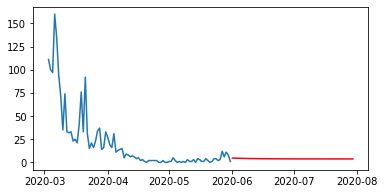

In [255]:
plt.figure(figsize=(6,3))
plt.plot(df_proj.index,df_proj['60_confirmed'])
plt.plot(df_proj.index,df_proj['Predictions'],color='red')
plt.show()

# Over 60 deceased

In [256]:
scaler=MinMaxScaler()
scaler.fit(train4)
train4=scaler.transform(train4)
test4=scaler.transform(test4)

n_input=60
n_features=1

generator=TimeseriesGenerator(train4,train4,length=n_input,batch_size=15)
model=Sequential()
model.add(LSTM(200,activation='relu',input_shape=(n_input,n_features)))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

model.fit_generator(generator,epochs=100)

pred_list4=[]

batch=train4[-n_input:].reshape((1,n_input,n_features))

for i in range(n_input):
  pred_list4.append(model.predict(batch)[0])
  batch=np.append(batch[:,1:,:],[[pred_list4[i]]],axis=1)

df4_predict=pd.DataFrame(scaler.inverse_transform(pred_list4),index=df4[-n_input:].index,columns=['Predictions'])

df_test4=pd.concat([df4,df4_predict],axis=1)
df_test4

Epoch 1/100
1/1 [==============================] - 0s 491ms/step - loss: 0.0500
Epoch 2/100
1/1 [==============================] - 0s 90ms/step - loss: 0.0448
Epoch 3/100
1/1 [==============================] - 0s 82ms/step - loss: 0.0392
Epoch 4/100
1/1 [==============================] - 0s 90ms/step - loss: 0.0338
Epoch 5/100
1/1 [==============================] - 0s 97ms/step - loss: 0.0290
Epoch 6/100
1/1 [==============================] - 0s 84ms/step - loss: 0.0232
Epoch 7/100
1/1 [==============================] - 0s 83ms/step - loss: 0.0181
Epoch 8/100
1/1 [==============================] - 0s 90ms/step - loss: 0.0150
Epoch 9/100
1/1 [==============================] - 0s 93ms/step - loss: 0.0116
Epoch 10/100
1/1 [==============================] - 0s 82ms/step - loss: 0.0205
Epoch 11/100
1/1 [==============================] - 0s 78ms/step - loss: 0.0156
Epoch 12/100
1/1 [==============================] - 0s 82ms/step - loss: 0.0100
Epoch 13/100
1/1 [==============================

,60_deceased,Predictions
date,,
2020-03-03,6,NaN
2020-03-04,4,NaN
2020-03-05,3,NaN
2020-03-06,7,NaN
2020-03-07,2,NaN
...,...,...
2020-05-27,0,1.496363
2020-05-28,0,1.496366
2020-05-29,0,1.496369


In [257]:
train4=df4

scaler.fit(train4)
train4=scaler.transform(train4)

n_input=60
n_features=1

generator=TimeseriesGenerator(train4,train4,length=n_input,batch_size=15)

model.fit_generator(generator,epochs=100)

pred_list4=[]

batch=train4[-n_input:].reshape((1,n_input,n_features))

for i in range(n_input):
  pred_list4.append(model.predict(batch)[0])
  batch=np.append(batch[:,1:,:],[[pred_list4[i]]],axis=1)


add_dates=[df4.index[-1]+DateOffset(days=x) for x in range(0,61)]
future_dates=pd.DataFrame(index=add_dates[1:],columns=df4.columns)

df_predict4=pd.DataFrame(scaler.inverse_transform(pred_list4),index=future_dates[-n_input:].index,columns=['Predictions'])
df_proj=pd.concat([df4,df_predict4],axis=1)
df_proj.tail(60)

Epoch 1/100
2/2 [==============================] - 0s 119ms/step - loss: 0.0169
Epoch 2/100
2/2 [==============================] - 0s 113ms/step - loss: 0.0135
Epoch 3/100
2/2 [==============================] - 0s 119ms/step - loss: 0.0109
Epoch 4/100
2/2 [==============================] - 0s 125ms/step - loss: 0.0102
Epoch 5/100
2/2 [==============================] - 0s 126ms/step - loss: 0.0108
Epoch 6/100
2/2 [==============================] - 0s 119ms/step - loss: 0.0112
Epoch 7/100
2/2 [==============================] - 0s 123ms/step - loss: 0.0114
Epoch 8/100
2/2 [==============================] - 0s 129ms/step - loss: 0.0111
Epoch 9/100
2/2 [==============================] - 0s 121ms/step - loss: 0.0109
Epoch 10/100
2/2 [==============================] - 0s 122ms/step - loss: 0.0108
Epoch 11/100
2/2 [==============================] - 0s 121ms/step - loss: 0.0106
Epoch 12/100
2/2 [==============================] - 0s 129ms/step - loss: 0.0105
Epoch 13/100
2/2 [===================

,60_deceased,Predictions
2020-06-01,NaN,0.586294
2020-06-02,NaN,0.577413
2020-06-03,NaN,0.569175
2020-06-04,NaN,0.561986
2020-06-05,NaN,0.555943
2020-06-06,NaN,0.550596
2020-06-07,NaN,0.546223
2020-06-08,NaN,0.542507
2020-06-09,NaN,0.539142
2020-06-10,NaN,0.536272


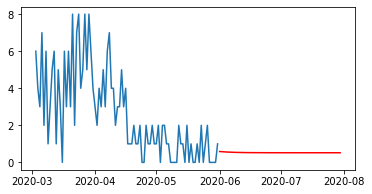

In [258]:
plt.figure(figsize=(6,3))
plt.plot(df_proj.index,df_proj['60_deceased'])
plt.plot(df_proj.index,df_proj['Predictions'],color='red')
plt.show()